# 01. Principes fondamentaux du Workflow PyTorch

L’essence de l’apprentissage automatique et de l’apprentissage profond est d'analyser certaines données du passé, de créer un algorithme (comme un réseau neuronal) pour y découvrir des modèles et d’utiliser les modèles découverts pour prédire l’avenir.

Il existe de nombreuses façons d’y parvenir et de nombreuses nouvelles façons sont constamment découvertes.


Et si on commençait par une ligne droite ?

Et nous voyons si nous pouvons créer un modèle PyTorch qui apprend le modèle de la ligne droite et le fait correspondre sur les données futures.

## Ce que nous allons aborder

Dans ce notebook, nous allons aborder un flux de travail PyTorch standard (il peut être découpé et modifié si nécessaire, mais il couvre les grandes lignes des étapes).

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01_a_pytorch_workflow.png" width=900 alt="un workflow de flux de travail pytorch"/>

Pour l'instant, nous utiliserons ce flux de travail pour prédire une simple ligne droite, mais les étapes du flux de travail peuvent être répétées et modifiées en fonction du problème sur lequel vous travaillez.

Plus précisément, nous allons couvrir :

| **Sujet** | **Contenu** |
| ----- | ----- |
| **1. Préparer les données** | Les données peuvent être presque n'importe quoi, mais pour commencer, nous allons créer une simple ligne droite |
| **2. Construire un modèle** | Ici, nous allons créer un modèle pour apprendre des modèles dans les données, nous choisirons également une **fonction de perte**, un **optimiseur** et créerons une **boucle d'entraînement**. |
| **3. Ajustement du modèle aux données (Entrainement)** | Nous avons des données et un modèle, laissons maintenant le modèle (essayer de) trouver des structures dans les données (**pattern**). |
| **4. Faire des prédictions et évaluer un modèle (Inférence)** | Les pattern trouvés par notre modèle dans les données sont évaluer et vérifier sur des données réelles (**tests**). |
| **5. Sauvegarder et charger un modèle** | Vous souhaiterez peut-être utiliser votre modèle ailleurs, cela consiste à stoquer les paramètres et l'architecture du modèle |

In [ ]:
Notre_Workflow_Pytorch = {
    1: "load dataset",
    2: "build model",
    3: "fit model to data (Training)",
    4: "predict and evaluate the model (Inference)",
    5: "save and load trained model",
}

Et maintenant importons ce dont nous aurons besoin pour ce notebook.
Nous allons charger `torch`, `torch.nn` (`nn` signifie réseau neuronal et ce package contient les éléments de base pour créer des réseaux neuronaux dans PyTorch) et `matplotlib`.

In [ ]:
import torch
from torch import nn # nn contient tous les couches de composition qui forme l'architecture d'un néseaux de neurones
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'2.1.0+cu118'

## 1. Données (préparation et chargement)

Je tiens à souligner que les « données » dans l'apprentissage automatique peuvent être presque tout ce que vous pouvez imaginer. Un tableau de nombres (comme une grande feuille de calcul Excel), des images de toutes sortes, des vidéos (YouTube regorge de données !), des fichiers audio comme des chansons ou des podcasts, des structures protéiques, du texte et bien plus encore.

![L'apprentissage automatique est un jeu en deux parties : 1. transformez vos données en un ensemble représentatif de nombres et 2. construisez ou choisissez une architecture de modèle pour apprendre la représentation du mieux possible](https://raw.githubusercontent.com/ mrdbourke/pytorch-deep-learning/main/images/01-machine-learning-a-game-of-two-parts.png)

L'apprentissage automatique est un jeu en deux parties :
1. Transformez vos données, quelles qu'elles soient, en chiffres (une représentation).
2. Choisissez ou construisez une architecture de modèles pour apprendre au mieux la représentation des données.

Parfois, un et deux peuvent être effectués en même temps.

Mais que se passe-t-il si vous n’avez pas de données ?

Eh bien, c'est là où nous en sommes actuellement.

Pas de données.

Mais nous pouvons en créer.

Créons nos données sous forme de ligne droite.

Nous utiliserons la [régression linéaire](https://en.wikipedia.org/wiki/Linear_regression) pour créer les données avec des **paramètres** connus (des choses qui peuvent être apprises par un modèle), puis nous utiliserons PyTorch pour voir si nous pouvons créer un modèle pour estimer ces paramètres en utilisant l'algorithme de [**gradient descent**](https://en.wikipedia.org/wiki/Gradient_descent).


In [ ]:
# set line *"unknown"* parameters to be estimated later
weight = 0.7
bias = 0.3

# Create data
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

Nous allons maintenant passer à la construction d'un modèle capable d'apprendre la relation entre « X » (**caractéristiques**) et « y » (**étiquettes**).

### Diviser les données en ensembles d'entraînement et de test

Nous avons maintenant des données mais avant de construire un modèle, nous devons les diviser en plusieurs parties.

L'une des étapes les plus importantes d'un projet d'apprentissage automatique consiste à créer un ensemble d'entrainement et de test (et, si nécessaire, un ensemble de validation).

Chaque fractionnement de l'ensemble de données répond à un objectif spécifique :

| Divisé | Objectif | Quantité de données totales | À quelle fréquence est-il utilisé ? |
| ----- | ----- | ----- | ----- |
| **Ensemble d'entrainement** | Le modèle apprend de ces données (comme les supports de cours que vous étudiez pendant le semestre). | ~60-80% | Toujours |
| **Ensemble de validation** | Le modèle est ajusté sur ces données (comme l'examen pratique que vous passez avant l'examen final). | ~10-20% | Souvent mais pas toujours |
| **Ensemble de test** | Le modèle est évalué sur ces données pour tester ce qu'il a appris (comme l'examen final que vous passez à la fin du semestre). | ~10-20% | Toujours |

Pour l'instant, nous utiliserons simplement un ensemble de formation et de test, cela signifie que nous aurons un ensemble de données sur lequel notre modèle pourra apprendre et être évalué.

Nous pouvons les créer en divisant nos tenseurs « X » et « y ».

> **Remarque :** Lorsqu'il s'agit de données du monde réel, cette étape est généralement effectuée dès le début d'un projet (l'ensemble de test doit toujours être séparé de toutes les autres données). Nous voulons que notre modèle apprenne sur les données d'entraînement, puis l'évalue sur les données de test pour avoir une indication de sa capacité à se **généraliser** à des exemples inédits.

In [ ]:
train_split = int(0.8 * len(X)) # 80% training set, 20% for testing
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

Nous avons 40 échantillons pour la formation (`X_train` & `y_train`) et 10 échantillons pour les tests (`X_test` & `y_test`).

Le modèle que nous créons va essayer d'apprendre la relation entre `X_train` et `y_train`, puis nous évaluerons ce qu'il apprend sur `X_test` et `y_test`.

Mais pour l’instant, nos données ne sont que des chiffres sur une page.

Créons une fonction pour le visualiser.

In [ ]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  plt.legend(prop={"size": 14});

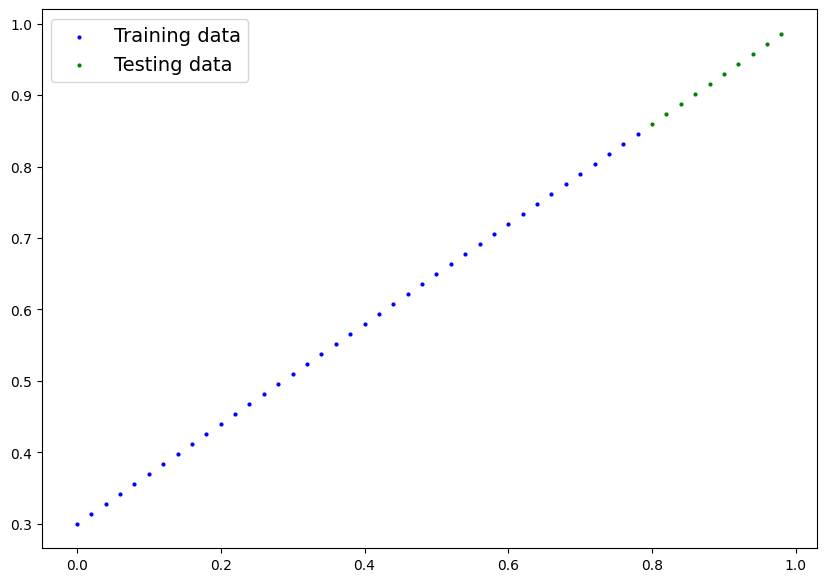

In [ ]:
plot_predictions();

Désormais, au lieu de simplement représenter des chiffres sur une page, nos données sont une ligne droite.

> **Remarque :** C'est le bon moment pour vous présenter la devise de l'explorateur de données... "visualiser, visualiser, visualiser !"
>
> Pensez-y chaque fois que vous travaillez avec des données et que vous les transformez en chiffres : si vous pouvez visualiser quelque chose, cela peut faire des merveilles pour la compréhension.
>
> Les machines aiment les chiffres et nous, les humains, aimons aussi les chiffres, mais nous aimons aussi regarder des graphes. Apres tout une image vaux plus d'un million de mots.

## 2. Construire un modèle

Maintenant que nous avons quelques données, construisons un modèle pour utiliser les points bleus pour prédire les points verts.

Reproduisons un modèle de régression linéaire standard en utilisant PyTorch native.

In [ ]:
# Linear Regression model
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1,# tirer un nombre aléatoire suivant la loi normale pour les weights
                                                dtype=torch.float), #forcer le type float32
                                   requires_grad=True)# suivi des opérations effectuées avec les weights pour calcul du gradient

        self.bias = nn.Parameter(torch.randn(1, # tirer un nombre aleatoire suivant la loi normale pour le bias
                                            dtype=torch.float), #forcer le type float32
                                requires_grad=True)# suivi des opérations effectuées avec les bias pour calcul du gradient

    # Phase avant qui definie l'architecture du modèle
    def forward(self, x: torch.Tensor) -> torch.Tensor: #"x" est le tenseur des caractéristiques d'input
        return self.weights * x + self.bias # modèle de regression linéaire simple (y = m*x + b)

> **Ressource :** Nous utiliserons des classes Python pour créer des éléments permettant de créer des réseaux de neurones. Si vous n'êtes pas familier avec la notation de classe Python, je vous recommande de lire le [Guide de programmation orientée objet de Real Python dans Python 3](https://realpython.com/python3-object-oriented-programming/) plusieurs fois.



### Guide de création de modèles PyTorch

PyTorch dispose de quatre modules essentiels que vous pouvez utiliser pour créer presque tous les types de réseaux neuronaux que vous pouvez imaginer.

Il s'agit de [`torch.nn`](https://pytorch.org/docs/stable/nn.html), [`torch.optim`](https://pytorch.org/docs/stable/optim.html ), [`torch.utils.data.Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) et [`torch.utils.data.Data.DataLoader`] (https://pytorch.org/docs/stable/data.html). Pour l'instant, nous allons nous concentrer sur les deux premiers.

| Module PyTorch | Qu'est ce que ça fait? |
| ----- | ----- |
| [`torch.nn`](https://pytorch.org/docs/stable/nn.html) | Contient tous les éléments constitutifs des graphiques informatiques (essentiellement une série de calculs exécutés d’une manière particulière). |
| [`torch.nn.Parameter`](https://pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html#parameter) | Stocke les tenseurs qui peuvent être utilisés avec `nn.Module`. Si les dégradés `requires_grad=True` (utilisés pour mettre à jour les paramètres du modèle via [**gradient descente**](https://ml-cheatsheet.readthedocs.io/en/latest/gradient_descent.html)) sont calculés automatiquement, c'est souvent appelé « autograd ». |
| [`torch.nn.Module`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module) | La classe de base pour tous les modules de réseaux neuronaux, tous les éléments constitutifs des réseaux neuronaux sont des sous-classes. Si vous construisez un réseau neuronal dans PyTorch, vos modèles doivent forcement hériter de « nn.Module » et nécessite qu'une méthode `forward()` soit implémentée. |
| [`torch.optim`](https://pytorch.org/docs/stable/optim.html) | Contient divers algorithmes d'optimisation (ceux-ci indiquent aux paramètres du modèle stockés dans « nn.Parameter » comment modifier au mieux pour améliorer la descente de gradient et, par conséquent, réduire la perte). |
| `def forward()` | Toutes les sous-classes `nn.Module` nécessitent une méthode `forward()`, celle-ci définit le calcul qui aura lieu sur les données transmises au `nn.Module` particulier (par exemple la formule de régression linéaire ci-dessus). |

Pensez à ceci : presque tout dans un réseau neuronal PyTorch provient de « torch.nn »,
* `nn.Module` contient les plus grands blocs de construction (couches)
* `nn.Parameter` contient les paramètres les plus petits comme les poids et les biais (assemblez-les pour créer `nn.Module`(s))
* `forward()` indique aux blocs plus gros comment effectuer des calculs sur les entrées (tenseurs pleins de données) dans `nn.Module`(s)
* `torch.optim` contient des méthodes d'optimisation sur la façon d'améliorer les paramètres dans `nn.Parameter` pour mieux représenter les données d'entrée.

![un modèle linéaire pytorch avec annotations](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01-pytorch-linear-model-annotated.png)

* Éléments de base de la création d'un modèle PyTorch en héritant de «nn.Module». Pour les objets qui sous-classent `nn.Module`, la méthode `forward()` doit être définie.*

> **Ressource :** Découvrez plus de ces modules essentiels et leurs cas d'utilisation dans la [PyTorch Cheat Sheet](https://pytorch.org/tutorials/beginner/ptcheat.html).


### Vérifier le contenu d'un modèle PyTorch
Maintenant que nous avons réglé tout cela, créons une instance de modèle avec la classe que nous avons créée et vérifions ses paramètres à l'aide de [`.parameters()`](https://pytorch.org/docs/stable/generated /torch.nn.Module.html#torch.nn.Module.parameters).

In [ ]:
torch.manual_seed(42)

model_0 = LinearRegressionModel()

list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

Nous pouvons également obtenir l'état (ce que contient le modèle) du modèle en utilisant [`.state_dict()`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn .Module.state_dict).

In [ ]:
# énumerer les paramètres du modèle sous forme de variables nommées
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

Remarquez comment les valeurs de « poids » et « biais » de « model_0.state_dict() » apparaissent sous forme de tenseurs flottants aléatoires ?

C'est parce que nous les avons initialisés ci-dessus en utilisant `torch.randn()`.

Essentiellement, nous voulons partir de paramètres aléatoires et faire en sorte que le modèle les mette à jour vers les paramètres qui correspondent le mieux à nos données (les valeurs de « poids » et de « biais » codées en dur que nous avons définies lors de la création de nos données en ligne droite).

> **Exercice :** Essayez de modifier la valeur de `torch.manual_seed()` deux cellules ci-dessus, voyez ce qui arrive aux poids et aux valeurs de biais.

Étant donné que notre modèle commence avec des valeurs aléatoires, son pouvoir prédictif est actuellement faible.

### Faire des prédictions en utilisant `torch.inference_mode()`
Pour vérifier cela, nous pouvons lui transmettre les données de test « X_test » pour voir à quel point elles prédisent « y_test ».

Lorsque nous transmettons des données à notre modèle, celles-ci passent par la méthode `forward()` du modèle et produisent un résultat en utilisant le calcul que nous avons défini.

Faisons quelques prédictions.

In [ ]:
with torch.inference_mode():
    y_preds = model_0(X_test)

# Alternative :
# with torch.no_grad():
#   y_preds = model_0(X_test)

Vous avez probablement remarqué que nous utilisons [`torch.inference_mode()`](https://pytorch.org/docs/stable/generated/torch.inference_mode.html) comme [gestionnaire de contexte](https://realpython.com/python-with-statement/) (c'est ce qu'est `with torch.inference_mode():`) pour faire les prédictions.

Comme son nom l'indique, `torch.inference_mode()` est utilisé lors de l'utilisation d'un modèle pour l'inférence (faire des prédictions).

`torch.inference_mode()` désactive plusieurs choses propore à l'entrainement (comme le suivi des gradients, qui est nécessaire pour le calcul des gradients mais pas utile pour l'inférence) pour accélérer les **passes avant** de notre modèle (les données passant par la méthode `forward()`) .

Nous avons fait quelques prédictions, voyons à quoi elles ressemblent.

In [ ]:
# Check the predictions
print(f"Number of testing samples: {len(X_test)}")
print(f"Number of predictions made: {len(y_preds)}")
print(f"Predicted values:\n{y_preds}")

Number of testing samples: 10
Number of predictions made: 10
Predicted values:
tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])


Remarquez qu'il existe une valeur de prédiction par échantillon de test.

Cela est dû au type de données que nous utilisons. Pour notre ligne droite, une valeur « X » correspond à une valeur « y ».

Cependant, les modèles d’apprentissage automatique sont très flexibles. Vous pouvez avoir 100 valeurs « X » mappées sur une, deux, trois ou 10 valeurs « y ». Tout dépend de ce sur quoi vous travaillez.

Nos prédictions sont toujours des nombres sur une page, visualisons-les avec notre fonction `plot_predictions()` que nous avons créée ci-dessus.

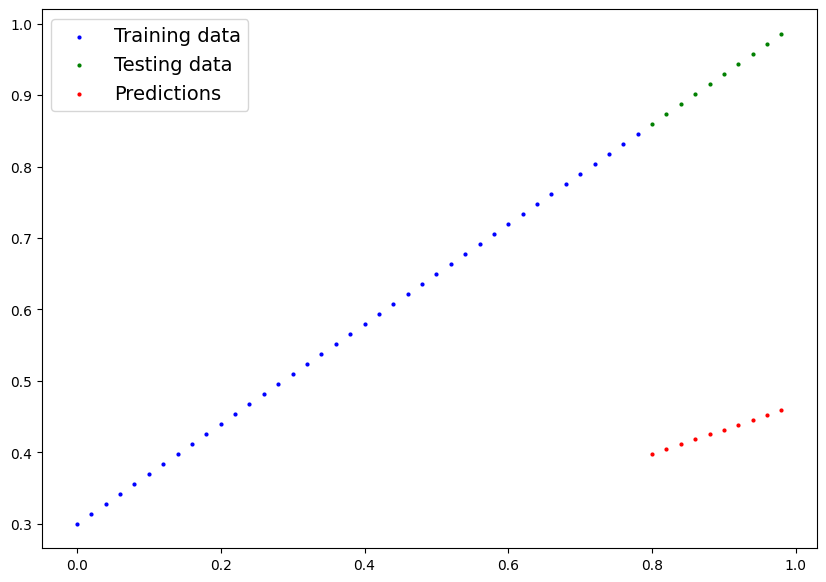

In [ ]:
plot_predictions(predictions=y_preds)

In [ ]:
y_test - y_preds

tensor([[0.4618],
        [0.4691],
        [0.4764],
        [0.4836],
        [0.4909],
        [0.4982],
        [0.5054],
        [0.5127],
        [0.5200],
        [0.5272]])

Ces prédictions semblent plutôt mauvaises...

Cela a du sens si l’on se souvient que notre modèle utilise simplement des valeurs de paramètres aléatoires pour faire des prédictions.

Il n’a même pas examiné les points bleus pour tenter de prédire les points verts.

Il est temps de changer cela.

## 3. Entrainement du Modèle

En ce moment, notre modèle fait des prédictions en utilisant des paramètres aléatoires pour effectuer des calculs, il s'agit essentiellement de deviner (au hasard).

Pour résoudre ce problème, nous pouvons mettre à jour ses paramètres internes, on fait référence aux *paramètres* du modèles, les valeurs `weights` et `bias` que nous définissons aléatoirement en utilisant `nn.Parameter()` et `torch.randn()` être quelque chose qui représente mieux les données.

Nous pourrions coder cela en dur (puisque nous connaissons les valeurs par défaut « poids=0,7 » et « biais=0,3 ») mais dans le cas réelle ces valeurs ne sont pas facile à deviner pour des datasets complexes ?

La plupart du temps, vous ne saurez pas quels sont les paramètres idéaux pour un modèle.

Au lieu de cela, notre code implémentant le modèle de régression linéaire peut essayer de les comprendre lui-même.

### Création d'une fonction de perte et d'un optimiseur dans PyTorch

Pour que notre modèle mette à jour ses paramètres tout seul, nous devrons ajouter quelques éléments supplémentaires à notre code.

Et c'est une ***loss***, autrement une **fonction de perte** ainsi qu'un **optimiseur**.

Les rôles de ceux-ci sont :

| Fonction | Qu'est ce que ça fait? | Où vit-il dans PyTorch ? | Valeurs communes |
| ----- | ----- | ----- | ----- |
| **Fonction de perte** | Mesure à quel point les prédictions de vos modèles (par exemple « y_preds ») sont comparées aux étiquettes de vérité (par exemple « y_test »). Baissez, mieux c'est. | PyTorch possède de nombreuses fonctions de perte intégrées dans [`torch.nn`](https://pytorch.org/docs/stable/nn.html#loss-functions). | Erreur absolue moyenne (MAE) pour les problèmes de régression ([`torch.nn.L1Loss()`](https://pytorch.org/docs/stable/generated/torch.nn.L1Loss.html)). Entropie croisée binaire pour les problèmes de classification binaire ([`torch.nn.BCELoss()`](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html)). |
| **Optimiseur** | Indique à votre modèle comment mettre à jour ses paramètres internes pour réduire au mieux la perte. | Vous pouvez trouver diverses implémentations de fonctions d'optimisation dans [`torch.optim`](https://pytorch.org/docs/stable/optim.html). | Descente de gradient stochastique ([`torch.optim.SGD()`](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD)). Optimiseur Adam ([`torch.optim.Adam()`](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)). |

Créons une fonction de perte et un optimiseur que nous pouvons utiliser pour améliorer notre modèle.

Le type de problème sur lequel vous travaillez dépendra de la fonction de perte et de l'optimiseur que vous utilisez.

Cependant, il existe certaines valeurs communes, connues pour bien fonctionner, telles que le SGD (descente de gradient stochastique) ou l'optimiseur Adam. Et la fonction de perte MAE (erreur absolue moyenne) pour les problèmes de régression (prédire un nombre) ou la fonction de perte d'entropie croisée binaire pour les problèmes de classification (prédire une chose ou une autre).

Pour notre problème, puisque nous prédisons un nombre, utilisons MAE (qui se trouve sous `torch.nn.L1Loss()`) dans PyTorch comme fonction de perte.

![à quoi ressemble la perte MAE pour nos données de tracé](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01-mae-loss-annotated.png)
*L'erreur absolue moyenne (MAE, dans PyTorch : `torch.nn.L1Loss`) mesure la différence absolue entre deux points (prédictions et étiquettes), puis prend la moyenne pour tous les exemples.*

Et nous utiliserons SGD, `torch.optim.SGD(params, lr)` où :

* `params` correspond aux paramètres du modèle cible que vous souhaitez optimiser (par exemple, les valeurs `weights` et `bias` que nous avons définies de manière aléatoire auparavant).
* `lr` est le **taux d'apprentissage** auquel vous souhaitez que l'optimiseur mette à jour les paramètres, un niveau plus élevé signifie que l'optimiseur essaiera des mises à jour plus importantes (celles-ci peuvent parfois être trop volumineuses et l'optimiseur ne fonctionnera pas), un niveau inférieur signifie l'optimiseur tentera des mises à jour plus petites (celles-ci peuvent parfois être trop petites et l'optimiseur mettra trop de temps à trouver les valeurs idéales). Le taux d'apprentissage est considéré comme un **hyperparamètre** (car il est défini par un ingénieur en apprentissage automatique). Les valeurs de départ courantes pour le taux d'apprentissage sont « 0,01 », « 0,001 », « 0,0001 », cependant, elles peuvent également être ajustées au fil du temps (c'est ce qu'on appelle [programmation du taux d'apprentissage](https://pytorch.org/docs/stable /optim.html#how-to-adjust-learning-rate)).

In [ ]:
loss_fn = nn.L1Loss() # MAE loss is same as L1Loss

optimizer = torch.optim.SGD(
    params=model_0.parameters(),
    lr=0.01)

### Création d'une boucle d'optimisation dans PyTorch

Maintenant que nous avons une fonction de perte et un optimiseur, il est maintenant temps de créer une **boucle d'entraînement** (et une **boucle de test**).

La boucle de formation implique que le modèle parcoure les données de formation et apprenne les relations entre les « fonctionnalités » et les « étiquettes ».

La boucle de test consiste à parcourir les données de test et à évaluer la qualité des modèles appris par le modèle sur les données d'entraînement (le modèle ne voit jamais les données de test pendant l'entraînement).

Chacun d'entre eux est appelé une « boucle » car nous voulons que notre modèle examine (en boucle) chaque échantillon de chaque ensemble de données.

Pour les créer, nous allons écrire une boucle Python `for` dans le thème de la [chanson de boucle d'optimisation non officielle de PyTorch](https://twitter.com/mrdbourke/status/1450977868406673410?s=20) (il y a un [ version vidéo également](https://youtu.be/Nutpusq_AFw)).

![la chanson non officielle de la boucle d'optimisation de pytorch](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01-pytorch-optimization-loop-song.png)
*La chanson non officielle des boucles d'optimisation PyTorch, une façon amusante de se souvenir des étapes d'une boucle de formation (et de test) PyTorch.*

Il y aura pas mal de code mais rien que nous ne puissions gérer.

### Boucle d'entraînement PyTorch
Pour la boucle d'entrainement, nous allons suivre les étapes suivantes :

| Numéro | Nom de l'étape | Qu'est ce que ça fait? | Exemple de code |
| ----- | ----- | ----- | ----- |
| 1 | Passe avant | Le modèle parcourt toutes les données d'entraînement une fois, effectuant ses calculs de fonction « forward() ». | `modèle(x_train)` |
| 2 | Calculer la perte | Les résultats du modèle (prédictions) sont comparés à la vérité terrain et évalués pour déterminer à quel point ils sont erronés. | `loss = loss_fn(y_pred, y_train)` |
| 3 | Gradient initial nulle  | Les gradients des optimiseurs sont mis à zéro (ils sont accumulés par défaut) afin qu'ils puissent être recalculés pour l'étape de formation spécifique. | `optimizer.zero_grad()` |
| 4 | Effectuer une rétropropagation sur la perte | Calcule le gradient de la perte en respectant chaque paramètre du modèle à mettre à jour (chaque paramètre avec `requires_grad=True`). C'est ce qu'on appelle la **rétropropagation**, donc "en arrière". | `loss.backward()` |
| 5 | Mettre à jour l'optimiseur (**descente de gradient**) | Mettez à jour les paramètres avec `requires_grad=True` par rapport aux gradients de perte afin de les améliorer. | `optimizer.step()` |

![boucle de formation pytorch annotée](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01-pytorch-training-loop-annotated.png)

> **Remarque :** Ce qui précède n'est qu'un exemple de la façon dont les étapes pourraient être ordonnées ou décrites. Avec l'expérience, vous constaterez que la création de boucles de formation PyTorch peut être assez flexible.
>
> Et concernant l'ordre des choses, ce qui précède est un bon ordre par défaut mais vous pouvez voir des ordres légèrement différents. Quelques règles empiriques :
> * Calculez la perte (`loss = ...`) *avant* d'effectuer une rétropropagation dessus (`loss.backward()`).
> * Zéro Gradient (`optimizer.zero_grad()`) *avant* de les mise à jour des poids (`optimizer.step()`).
> * Étape de l'optimiseur (`optimizer.step()`) *après* avoir effectué une rétropropagation sur la perte (`loss.backward()`).

### Boucle de test PyTorch

Quant à la boucle de test (évaluation de notre modèle), les étapes typiques comprennent :

| Numéro | Nom de l'étape | Qu'est ce que ça fait? | Exemple de code |
| ----- | ----- | ----- | ----- |
| 1 | Passe avant | Le modèle parcourt toutes les données d'entraînement une fois, effectuant ses calculs de fonction « forward() ». | `modèle(x_test)` |
| 2 | Calculer la perte | Les résultats du modèle (prédictions) sont comparés à la vérité terrain et évalués pour déterminer à quel point ils sont erronés. | `loss = loss_fn(y_pred, y_test)` |
| 3 | Calculer les métriques d'évaluation (facultatif) | Parallèlement à la valeur de perte, vous souhaiterez peut-être calculer d'autres mesures d'évaluation telles que la précision de l'ensemble de test. | Fonctions personnalisées |

Notez que la boucle de test ne contient pas d'exécution de rétropropagation (`loss.backward()`) ni d'étape de l'optimiseur (`optimizer.step()`), car aucun paramètre du modèle n'est modifié pendant le test, ils ont déjà été calculé. Pour les tests, nous nous intéressons uniquement à la sortie du passage direct à travers le modèle.

![boucle de test annotée pytorch](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01-pytorch-testing-loop-annotated.png)

Rassemblons tout ce qui précède et entraînons notre modèle pour 150 **époques** (passages en avant à travers les données) et nous l'évaluerons toutes les 10 époques.

In [ ]:
torch.manual_seed(42)

epochs = 150

train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
    ### Training

    # Put model in training mode (this is the default state of a model)
    model_0.train()

    # 1. Forward pass on train data using the forward() method inside
    y_pred = model_0(X_train)
    # print(y_pred)

    # 2. Calculate the loss (how different are our models predictions to the ground truth)
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad of the optimizer
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Progress the optimizer
    optimizer.step()

    ### Testing

    # Put the model in evaluation mode
    model_0.eval()

    with torch.inference_mode():
      # 1. Forward pass on test data
      test_pred = model_0(X_test)

      # 2. Caculate loss on test data
      test_loss = loss_fn(test_pred, y_test.type(torch.float))

      # Print out what's happening
      if epoch % 10 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")

Epoch: 0 | MAE Train Loss: 0.31288138031959534 | MAE Test Loss: 0.48106518387794495 
Epoch: 10 | MAE Train Loss: 0.1976713240146637 | MAE Test Loss: 0.3463551998138428 
Epoch: 20 | MAE Train Loss: 0.08908725529909134 | MAE Test Loss: 0.21729660034179688 
Epoch: 30 | MAE Train Loss: 0.053148526698350906 | MAE Test Loss: 0.14464017748832703 
Epoch: 40 | MAE Train Loss: 0.04543796554207802 | MAE Test Loss: 0.11360953003168106 
Epoch: 50 | MAE Train Loss: 0.04167863354086876 | MAE Test Loss: 0.09919948130846024 
Epoch: 60 | MAE Train Loss: 0.03818932920694351 | MAE Test Loss: 0.08886633068323135 
Epoch: 70 | MAE Train Loss: 0.03476089984178543 | MAE Test Loss: 0.0805937647819519 
Epoch: 80 | MAE Train Loss: 0.03132382780313492 | MAE Test Loss: 0.07232122868299484 
Epoch: 90 | MAE Train Loss: 0.02788739837706089 | MAE Test Loss: 0.06473556160926819 
Epoch: 100 | MAE Train Loss: 0.024458957836031914 | MAE Test Loss: 0.05646304413676262 
Epoch: 110 | MAE Train Loss: 0.021020207554101944 | MAE

On dirait que notre perte diminue à chaque époque, traçons-la pour découvrir son évolution.

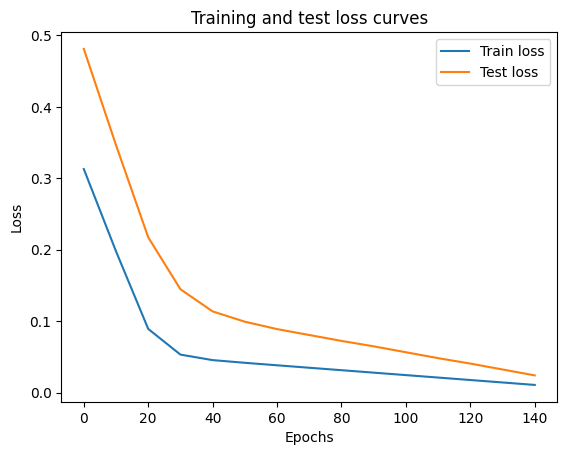

In [ ]:
# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

Les **courbes de perte** montrent que la loss diminue avec le temps. N'oubliez pas que la perte est la mesure de l'*erreur* de votre modèle, donc plus elle est faible, mieux c'est.

Mais pourquoi la perte a-t-elle diminué ?

Eh bien, grâce à notre fonction de perte et à notre optimiseur, les paramètres internes du modèle (« poids » et « biais ») ont été mis à jour pour mieux refléter les modèles sous-jacents dans les données.

Inspectons le [`.state_dict()`](https://pytorch.org/tutorials/recipes/recipes/what_is_state_dict.html) de notre modèle pour voir à quel point notre modèle se rapproche des valeurs d'origine que nous avons définies pour les poids et les biais.

In [ ]:
# Find our model's learned parameters
print("The model learned the following values for weights and bias:")
print(model_0.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('weights', tensor([0.6638])), ('bias', tensor([0.3153]))])

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


Notre modèle s'est rapproché du calcul des valeurs originales exactes du « poids » et du « biais » (et il serait probablement encore plus proche si nous l'entraînions plus longtemps).

> **Exercice :** Essayez de changer la valeur « époques » ci-dessus à 200, qu'arrive-t-il aux courbes de perte et aux valeurs des paramètres de pondération et de biais du modèle ?

Il ne les devinerait probablement jamais *parfaitement* (surtout lorsque vous utilisez des ensembles de données plus complexes), mais ce n'est pas grave, vous pouvez souvent faire des choses très intéressantes avec une approximation proche.

C'est toute l'idée de l'apprentissage automatique et de l'apprentissage profond, **il existe des valeurs idéales qui décrivent nos données** et plutôt que de les comprendre manuellement, **nous pouvons entraîner un modèle pour les comprendre par programme**.

## 4. Faire des prédictions avec un modèle PyTorch entraîné (inférence)

Une fois que vous avez entraîné un modèle, vous souhaiterez probablement faire des prédictions avec celui-ci.

Nous en avons déjà eu un aperçu dans le code de formation et de test ci-dessus, les étapes pour le faire en dehors de la boucle de formation/test sont similaires.

Il y a trois choses à retenir lors de la réalisation de prédictions (également appelées inférences) avec un modèle PyTorch :

1. Définissez le modèle en mode évaluation (`model.eval()`).
2. Faites les prédictions à l'aide du gestionnaire de contexte du mode d'inférence (`with torch.inference_mode() : ...`).
3. Toutes les prédictions doivent être effectuées avec des objets sur le même appareil (par exemple, données et modèle sur GPU uniquement ou données et modèle sur CPU uniquement).

Les deux premiers éléments garantissent que tous les calculs et paramètres utiles que PyTorch utilise en coulisses pendant l'entrainement, mais qui ne sont pas nécessaires à l'inférence, sont désactivés (cela se traduit par un calcul plus rapide). Et le troisième garantit que vous ne rencontrerez pas d’erreurs multi-appareils.

In [ ]:
# 1. Set the model in evaluation mode
model_0.eval()

# 2. Setup the inference mode context manager
with torch.inference_mode():
  # 3. Make sure the calculations are done with the model and data on the same device
  # in our case, we haven't setup device-agnostic code yet so our data and model are
  # on the CPU by default.
  # model_0.to(device)
  # X_test = X_test.to(device)
  y_preds = model_0(X_test)
y_preds

tensor([[0.8464],
        [0.8596],
        [0.8729],
        [0.8862],
        [0.8995],
        [0.9127],
        [0.9260],
        [0.9393],
        [0.9526],
        [0.9659]])

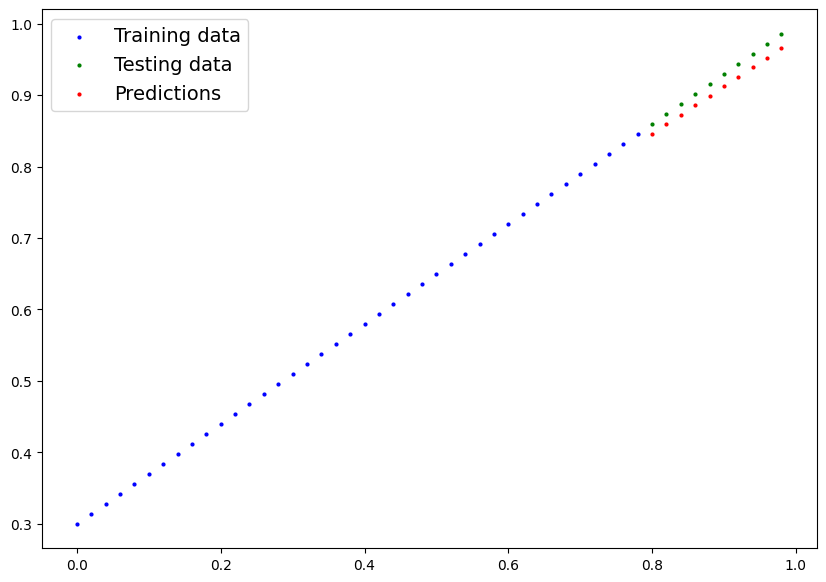

In [ ]:
plot_predictions(predictions=y_preds)

Le modèle semble apprendre bien la structure des données ligne et leurs positionement.

Passons à la sauvegarde et au rechargement d'un modèle dans PyTorch.

## 5. Sauvegarder et charger un modèle PyTorch

Si vous avez entraîné un modèle PyTorch, vous souhaiterez probablement le sauvegarder et l'exporter quelque part.

Par exemple, vous pouvez l'entraîner sur Google Colab ou sur votre ordinateur local avec un GPU, mais vous souhaitez maintenant l'exporter vers une sorte d'application où d'autres peuvent l'utiliser.

Ou peut-être souhaitez-vous enregistrer votre progression sur un modèle et revenir le charger plus tard.

Pour enregistrer et charger des modèles dans PyTorch, vous devez connaître trois méthodes principales (toutes celles ci-dessous sont tirées du [Guide d'enregistrement et de chargement des modèles PyTorch](https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-loading-model-for-inference)):

| Méthode PyTorch | Qu'est ce que ça fait? |
| ----- | ----- |
| [`torch.save`](https://pytorch.org/docs/stable/torch.html?highlight=save#torch.save) | Enregistre un objet sérialisé sur le disque à l'aide de l'utilitaire [`pickle`](https://docs.python.org/3/library/pickle.html) de Python. Les modèles, tenseurs et divers autres objets Python tels que les dictionnaires peuvent être enregistrés à l'aide de « torch.save ». |
| [`torch.load`](https://pytorch.org/docs/stable/torch.html?highlight=torch%20load#torch.load) | Utilise les fonctionnalités de décapage de `pickle` pour désérialiser et charger des fichiers objets Python marinés (comme des modèles, des tenseurs ou des dictionnaires) en mémoire. Vous pouvez également définir sur quel appareil charger l'objet (CPU, GPU, etc.). |
| [`torch.nn.Module.load_state_dict`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html?highlight=load_state_dict#torch.nn.Module.load_state_dict)| Charge le dictionnaire de paramètres d'un modèle (`model.state_dict()`) à l'aide d'un objet `state_dict()` enregistré. |

> **Remarque :** Comme indiqué dans la [documentation `pickle` de Python](https://docs.python.org/3/library/pickle.html), le module `pickle` **n'est pas sécurisé**. Cela signifie que vous ne devez extraire (charger) que les données auxquelles vous faites confiance. Cela vaut également pour le chargement des modèles PyTorch. Utilisez uniquement des modèles PyTorch enregistrés provenant de sources de confiance.

### Sauvegarde du `state_dict()` d'un modèle PyTorch

La [méthode recommandée](https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-loading-model-for-inference) pour enregistrer et charger un modèle pour l'inférence (faire des prédictions) consiste à enregistrer et charger un `state_dict()` du modèle.

Voyons comment procéder en quelques étapes :

1. Nous allons créer un répertoire pour enregistrer les modèles appelé « models » à l'aide du module « pathlib » de Python.
2. Nous allons créer un chemin de fichier dans lequel enregistrer le modèle.
3. Nous appellerons `torch.save(obj, f)` où `obj` est le `state_dict()` du modèle cible et `f` est le nom de fichier où enregistrer le modèle.

> **Remarque :** Il est courant que les modèles ou objets enregistrés par PyTorch se terminent par `.pt` ou `.pth`, comme `saved_model_01.pth`.

In [ ]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_0.pth


In [ ]:
# Check the saved file path
!ls -l models/01_pytorch_workflow_model_0.pth

-rw-r--r-- 1 root root 1680 Nov  4 20:44 models/01_pytorch_workflow_model_0.pth


### Chargement du `state_dict()` d'un modèle PyTorch enregistré

Puisque nous avons maintenant un modèle enregistré `state_dict()` dans `models/01_pytorch_workflow_model_0.pth`, nous pouvons maintenant le charger en utilisant `torch.nn.Module.load_state_dict(torch.load(f))` où `f` est le chemin de fichier de notre modèle enregistré `state_dict()`.

Pourquoi appeler `torch.load()` dans `torch.nn.Module.load_state_dict()` ?

Parce que nous n'avons enregistré que le `state_dict()` du modèle qui est un dictionnaire de paramètres appris et non le modèle *entier*, nous devons d'abord charger le `state_dict()` avec `torch.load()` puis transmettre cela ` state_dict()` vers une nouvelle instance de notre modèle (qui est une sous-classe de `nn.Module`).

Pourquoi ne pas sauvegarder l'intégralité du modèle ?

[Enregistrer l'intégralité du modèle](https://pytorch.org/tutorials/beginner/saving_loading_models.html#save-load-entire-model) plutôt que simplement `state_dict()` est plus intuitif, cependant, pour citer le PyTorch documentation :

> L'inconvénient de cette approche *(sauvegarde de l'ensemble du modèle)* est que les données sérialisées sont liées aux classes spécifiques et à la structure de répertoires exacte utilisée lors de la sauvegarde du modèle...
>
> Pour cette raison, votre code peut échouer de diverses manières lorsqu'il est utilisé dans d'autres projets ou après des refactorisations.

Donc à la place, nous utilisons la méthode flexible de sauvegarde et de chargement uniquement de « state_dict() », qui encore une fois est essentiellement un dictionnaire de paramètres de modèle.

Testons-le en créant une autre instance de `LinearRegressionModel()`, qui est une sous-classe de `torch.nn.Module` et aura donc la méthode intégrée `load_state_dict()`.

In [ ]:
# Instantiate a new instance of our model (this will be instantiated with random weights)
loaded_model_0 = LinearRegressionModel()

# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

Maintenant, pour tester notre modèle chargé, effectuons une inférence avec lui (fabriquons des prédictions) sur les données de test.

Vous vous souvenez des règles pour effectuer une inférence avec les modèles PyTorch ?

Sinon, voici un rappel :

<details>
     <summary>Règles d'inférence PyTorch</summary>
     <ol>
       <li> Définir le modèle en mode évaluation (<code>model.eval()</code>). </li>
       <li> Faites les prédictions à l'aide du gestionnaire de contexte du mode d'inférence (<code>with torch.inference_mode() : ...</code>). </li>
       <li> Toutes les prédictions doivent être effectuées avec des objets sur le même appareil (par exemple, données et modèle sur GPU uniquement ou données et modèle sur CPU uniquement).</li>
     </ol>
</details>

In [ ]:
loaded_model_0.eval()

# 2. Use the inference mode context manager to make predictions
with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test) # perform a forward pass on the test data with the loaded model

In [ ]:
# Compare previous model predictions with loaded model predictions (these should be the same)
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

Il semble que les prédictions du modèle chargé sont les mêmes que les prédictions du modèle précédent (prédictions faites avant l'enregistrement). Cela indique que notre modèle est enregistré et chargé comme prévu.

> **Remarque :** Il existe d'autres méthodes pour enregistrer et charger des modèles PyTorch, mais je les laisserai pour des lectures extra-scolaires et complémentaires.

## 6. En conclusion :

Nous avons parcouru pas mal de chemin jusqu’à présent. Rassemblons tout ce que nous avons fait jusqu'à présent.

Sauf que cette fois, nous rendrons notre périphérique de code agnostique (donc s'il y a un GPU disponible, il l'utilisera et sinon, il utilisera par défaut le CPU).

In [71]:
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.__version__

'2.1.0+cu118'

In [72]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


In [76]:
# Create weight and bias
weight = 0.7
bias = 0.3

# Create range values
start = 0
end = 1
step = 0.01

# Create X and y (features and labels)
X = torch.arange(start, end, step).unsqueeze(dim=1) # without unsqueeze, errors will happen later on (shapes within linear layers)
y = weight * X + bias
X[:10], y[:10]

(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400],
         [0.0500],
         [0.0600],
         [0.0700],
         [0.0800],
         [0.0900]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280],
         [0.3350],
         [0.3420],
         [0.3490],
         [0.3560],
         [0.3630]]))

In [77]:
# Split data
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(80, 80, 20, 20)

Excellent, let's visualize them to make sure they look okay.

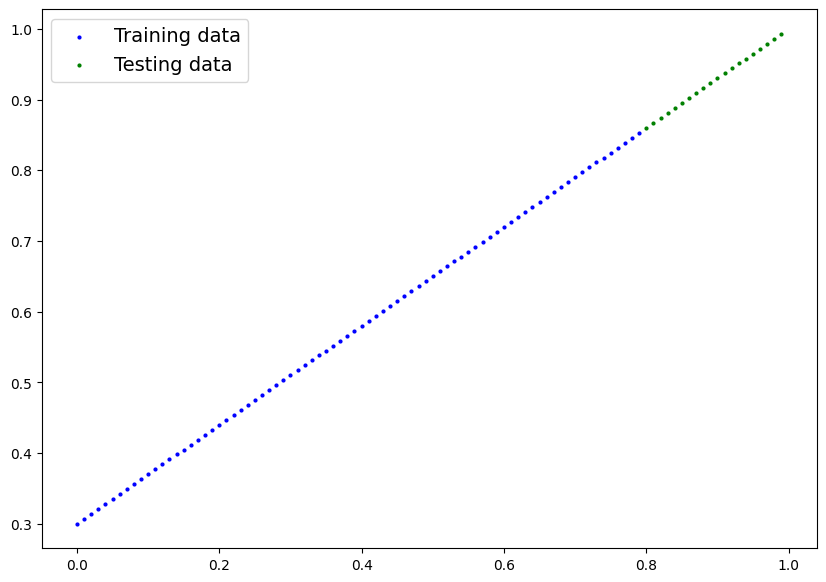

In [78]:
plot_predictions(X_train, y_train, X_test, y_test)

Nous allons créer le même style de modèle qu'avant sauf que cette fois, au lieu de définir manuellement les paramètres de poids et de biais de notre modèle à l'aide de `nn.Parameter()`, nous utiliserons [`nn.Linear(in_features, out_features) `](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) pour le faire pour nous.

Où « in_features » est le nombre de dimensions de vos données d'entrée et « out_features » est le nombre de dimensions dans lesquelles vous souhaitez qu'elles soient sorties.

Dans notre cas, ces deux éléments sont « 1 » puisque nos données ont « 1 » caractéristique d'entrée ( « X ») par étiquette ( « y »).

![comparaison du modèle de régression linéaire `nn.Parameter` et du modèle de régression linéaire `nn.Linear`](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01-pytorch-linear-regression-model-with-nn-Parameter-and-nn-Linear-compared.png)

*Création d'un modèle de régression linéaire en utilisant `nn.Parameter` plutôt qu'en utilisant `nn.Linear`. Il existe de nombreux autres exemples de cas où le module « torch.nn » dispose de calculs prédéfinis, y compris de nombreuses couches de réseau neuronal populaires et utiles.*

In [79]:
class LinearRegressionModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer = nn.Linear(in_features=1,
                                      out_features=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)

torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

Remarquez les sorties de `model_1.state_dict()`, la couche `nn.Linear()` a créé un paramètre aléatoire `weight` et `bias` pour nous.

Mettons maintenant notre modèle sur le GPU (s'il est disponible).

Nous pouvons changer l'appareil sur lequel se trouvent nos objets PyTorch en utilisant `.to(device)`.

Vérifions d’abord l’appareil actuel du modèle.

In [80]:
next(model_1.parameters()).device

device(type='cpu')

In [82]:
model_1.to(device)
next(model_1.parameters()).device

device(type='cpu')

In [83]:
# Create loss function
loss_fn = nn.L1Loss()

# Create optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(), # optimize newly created model's parameters
                            lr=0.01)

In [84]:
torch.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put data on the available device
# Without this, error will happen (not all model/data on device)
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
    ### Training
    model_1.train() # train mode is on by default after construction

    # 1. Forward pass
    y_pred = model_1(X_train)

    # 2. Calculate loss
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad optimizer
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Step the optimizer
    optimizer.step()

    ### Testing
    model_1.eval() # put the model in evaluation mode for testing (inference)
    # 1. Forward pass
    with torch.inference_mode():
        test_pred = model_1(X_test)

        # 2. Calculate the loss
        test_loss = loss_fn(test_pred, y_test)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Train loss: {loss} | Test loss: {test_loss}")

Epoch: 0 | Train loss: 0.5555006265640259 | Test loss: 0.5742346048355103
Epoch: 100 | Train loss: 0.006589989177882671 | Test loss: 0.014520359225571156
Epoch: 200 | Train loss: 0.006687174551188946 | Test loss: 0.009153103455901146
Epoch: 300 | Train loss: 0.006687174551188946 | Test loss: 0.009153103455901146
Epoch: 400 | Train loss: 0.006687174551188946 | Test loss: 0.009153103455901146
Epoch: 500 | Train loss: 0.006687174551188946 | Test loss: 0.009153103455901146
Epoch: 600 | Train loss: 0.006687174551188946 | Test loss: 0.009153103455901146
Epoch: 700 | Train loss: 0.006687174551188946 | Test loss: 0.009153103455901146
Epoch: 800 | Train loss: 0.006687174551188946 | Test loss: 0.009153103455901146
Epoch: 900 | Train loss: 0.006687174551188946 | Test loss: 0.009153103455901146


> **Remarque :** En raison de la nature aléatoire de l'apprentissage automatique, vous obtiendrez probablement des résultats légèrement différents (valeurs de perte et de prédiction différentes) selon que votre modèle a été entraîné sur CPU ou GPU. Cela est vrai même si vous utilisez la même graine aléatoire sur l'un ou l'autre appareil. Si la différence est grande, vous souhaiterez peut-être rechercher des erreurs, mais si elle est petite (idéalement, elle l'est), vous pouvez l'ignorer.

Vérifions les paramètres que notre modèle a appris et comparons-les aux paramètres d'origine que nous avons codés en dur.

In [85]:
# Find our model's learned parameters
from pprint import pprint # pprint = pretty print, see: https://docs.python.org/3/library/pprint.html
print("The model learned the following values for weights and bias:")
pprint(model_1.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('linear_layer.weight', tensor([[0.6954]])),
             ('linear_layer.bias', tensor([0.3085]))])

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


In [88]:
# Turn model into evaluation mode
model_1.eval()

# Make predictions on the test data
with torch.inference_mode():
    y_preds = model_1(X_test)
y_preds

tensor([[0.8648],
        [0.8718],
        [0.8787],
        [0.8857],
        [0.8926],
        [0.8996],
        [0.9065],
        [0.9135],
        [0.9205],
        [0.9274],
        [0.9344],
        [0.9413],
        [0.9483],
        [0.9552],
        [0.9622],
        [0.9691],
        [0.9761],
        [0.9830],
        [0.9900],
        [0.9969]])

Si vous faites des prédictions avec des données sur le GPU, vous remarquerez peut-être que la sortie de ce qui précède comporte `device='cuda:0'` vers la fin. Cela signifie que les données se trouvent sur le périphérique CUDA 0 (le premier GPU auquel votre système a accès en raison de l'indexation zéro). Si vous finissez par utiliser plusieurs GPU à l'avenir, ce nombre peut être plus élevé.

Traçons maintenant les prédictions de notre modèle.

> **Remarque :** De nombreuses bibliothèques de science des données telles que pandas, matplotlib et NumPy ne sont pas capables d'utiliser les données stockées sur GPU. Vous pourriez donc rencontrer des problèmes lorsque vous essayez d'utiliser une fonction de l'une de ces bibliothèques avec des données tensorielles non stockées sur le processeur. Pour résoudre ce problème, vous pouvez appeler [`.cpu()`](https://pytorch.org/docs/stable/generated/torch.Tensor.cpu.html) sur votre tenseur cible pour renvoyer une copie de votre tenseur cible sur le processeur.

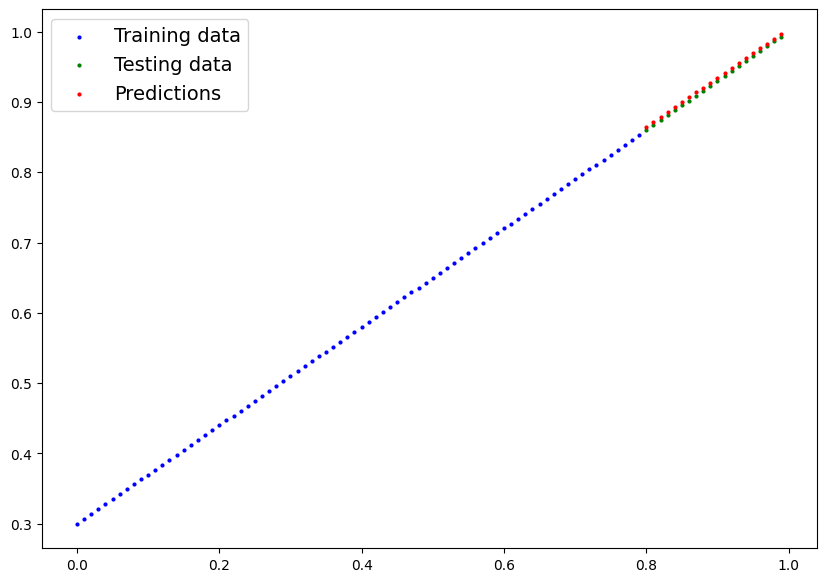

In [91]:
plot_predictions(X_train.cpu(), y_train.cpu(), X_test.cpu(), y_test.cpu(),y_preds.cpu())

In [92]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_1.pth


In [93]:
# Instantiate a fresh instance of LinearRegressionModelV2
loaded_model_1 = LinearRegressionModelV2()

# Load model state dict
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

# Put model to target device (if your data is on GPU, model will have to be on GPU to make predictions)
loaded_model_1.to(device)

print(f"Loaded model:\n{loaded_model_1}")
print(f"Model on device:\n{next(loaded_model_1.parameters()).device}")

Loaded model:
LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)
Model on device:
cpu


In [94]:
# Evaluate loaded model
loaded_model_1.eval()
with torch.inference_mode():
    loaded_model_1_preds = loaded_model_1(X_test)
y_preds == loaded_model_1_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

## Exercices

1. Créez un ensemble de données en ligne droite à l'aide de la formule de régression linéaire (« poids * X + biais »).
   * Définissez « poids = 0,3 » et « biais = 0,9 », il devrait y avoir au moins 100 points de données au total.
   * Divisez les données en 80 % de formation et 20 % de tests.
   * Tracez les données d'entrainement et de test pour qu'elles deviennent visuelles.
2. Créez un modèle PyTorch en sous-classant « nn.Module ».
   * À l'intérieur devrait se trouver un `nn.Parameter()` initialisé de manière aléatoire avec `requires_grad=True`, un pour les `poids` et un pour le `bias`.
   * Implémentez la méthode `forward()` pour calculer la fonction de régression linéaire que vous avez utilisée pour créer l'ensemble de données en 1.
   * Une fois que vous avez construit le modèle, créez-en une instance et vérifiez son `state_dict()`.
   * **Remarque :** Si vous souhaitez utiliser `nn.Linear()` au lieu de `nn.Parameter()`, vous le pouvez.
3. Créez une fonction de perte et un optimiseur en utilisant respectivement `nn.L1Loss()` et `torch.optim.SGD(params, lr)`.
   * Définissez le taux d'apprentissage de l'optimiseur sur 0,01 et les paramètres à optimiser doivent être les paramètres du modèle que vous avez créé en 2.
   * Écrivez une boucle de formation pour effectuer les étapes de formation appropriées pendant 300 époques.
   * La boucle de formation doit tester le modèle sur l'ensemble de données de test toutes les 20 époques.
4. Faites des prédictions avec le modèle entraîné sur les données de test.
   * Visualisez ces prédictions par rapport aux données d'entraînement et de test d'origine (**remarque :** vous devrez peut-être vous assurer que les prédictions ne sont *pas* sur le GPU si vous souhaitez utiliser des bibliothèques non compatibles CUDA telles que matplotlib pour tracer) .
5. Enregistrez le « state_dict() » de votre modèle entraîné dans un fichier.
   * Créez une nouvelle instance de votre classe de modèle que vous avez créée en 2. et chargez le `state_dict()` que vous venez d'y enregistrer.
   * Effectuez des prédictions sur vos données de test avec le modèle chargé et confirmez qu'elles correspondent aux prédictions du modèle d'origine de 4.


## BoNuS
* Écoutez [The Unofficial PyTorch Optimization Loop Song](https://youtu.be/Nutpusq_AFw) (pour vous aider à vous souvenir des étapes d'une boucle de formation/test PyTorch).
* Lisez [Qu'est-ce que `torch.nn`, vraiment ?](https://pytorch.org/tutorials/beginner/nn_tutorial.html) par Jeremy Howard pour une compréhension plus approfondie du fonctionnement de l'un des modules les plus importants de PyTorch.
* Passez 10 minutes à parcourir et à consulter la [aide-mémoire de la documentation PyTorch](https://pytorch.org/tutorials/beginner/ptcheat.html) pour tous les différents modules PyTorch que vous pourriez rencontrer.
* Passez 10 minutes à lire la [documentation de chargement et de sauvegarde sur le site Web de PyTorch](https://pytorch.org/tutorials/beginner/saving_loading_models.html) pour vous familiariser davantage avec les différentes options de sauvegarde et de chargement de PyTorch.
* Passez 1 à 2 heures à lire/regarder ce qui suit pour un aperçu des composants internes de la descente de gradient et de la rétropropagation, les deux principaux algorithmes qui ont fonctionné en arrière-plan pour aider notre modèle à apprendre.
  * [Page Wikipédia pour la descente de gradient](https://en.wikipedia.org/wiki/Gradient_descent)
  * [Algorithme de descente de gradient — une plongée en profondeur](https://towardsdatascience.com/gradient-descent-algorithm-a-deep-dive-cf04e8115f21) par Robert Kwiatkowski
  * [Descente de gradient, comment les réseaux de neurones apprennent la vidéo](https://youtu.be/IHZwWFHWa-w) par 3Blue1Brown
  * [Que fait réellement la rétropropagation ?](https://youtu.be/Ilg3gGewQ5U) vidéo de 3Blue1Brown
  * [Page Wikipédia sur la rétropropagation](https://en.wikipedia.org/wiki/Backpropagation)
  * Consultez le [guide PyTorch pour l'enregistrement et le chargement de modèles](https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-and-loading-models) pour en savoir plus.